In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
from scipy import stats
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
import seaborn as sns
from scipy.stats import weibull_min


In [2]:
df = pd.read_csv(r"altered_Med_data.csv")

In [3]:
pd.options.display.float_format = '{:,.0f}'.format
df['Initial_Days'].dtypes
df['Initial_Days'] = df['Initial_Days'].astype(int)

In [4]:
#df.head(5)

In [5]:
#df.describe()

In [6]:
#df.rename(columns={ df.columns[0]: "Original_order" }, inplace = True)


In [7]:
#df.describe()

In [8]:
df.shape

(10000, 76)

In [9]:
#df.head(5)

This section will run the code to apply some of the analysis techniques required,
First will be the Chi-square test of the ratios of two populations. This example will test the proportion of male patients who were readmitted vs the proportion of female patients who were readmitted.

Approach: The difference in population proportion needs t-test. Also, the population follows a binomial distribution here. We can just pass on the two population quantities with the appropriate binomial distribution parameters to the t-test function.
We can use thettest_ind() function from Statsmodels. The function returns three values: (a) test statistic, (b) p-value of the t-test, and (c) degrees of freedom used in the t-test.

In [10]:
import scipy.stats.distributions as dist

In [11]:
#df.head()

In [12]:
df['Gender'].value_counts(normalize=True) * 100

Female                 50
Male                   48
Prefer not to answer    2
Name: Gender, dtype: float64

In [13]:
to_drop = ['Prefer not to answer']
df = df[~df['Gender'].isin(to_drop)]

In [14]:
df = df.dropna(subset=['ReAdmis']) #drop nan values

In [15]:
df['ReAdmis'].value_counts(ascending=True)

Yes    3586
No     6200
Name: ReAdmis, dtype: int64

In [16]:
df['ReAdmis'].value_counts(normalize=True) * 100

No    63
Yes   37
Name: ReAdmis, dtype: float64

In [17]:
df['women_admis'] = (df['Gender'] == 'Female') & (df['ReAdmis'] == 'Yes')
df['men_admis'] = (df['Gender'] == 'Male') & (df['ReAdmis'] == 'Yes')


In [18]:
df['women_admis'].value_counts()

False    7973
True     1813
Name: women_admis, dtype: int64

In [19]:
df['men_admis'].value_counts()

False    8013
True     1773
Name: men_admis, dtype: int64

In [20]:
df['readmis_by_gender'] = np.where(df['women_admis']==True,'female',
np.where(df['men_admis']==True,'male',None))

In [21]:
#df.head(5)

Counts of ReAdmis by Sex

In [22]:
gender_ratio = df['readmis_by_gender'].value_counts()
df['readmis_by_gender'].value_counts()

female    1813
male      1773
Name: readmis_by_gender, dtype: int64

In [23]:
men_yes_count = len(df[(df['Gender'] == 'Male') & (df['ReAdmis'] == 'Yes')])
women_yes_count = len(df[(df['Gender'] == 'Female') & (df['ReAdmis'] == 'Yes')])
df.describe()
print(women_yes_count)
print(men_yes_count)
print('count of women readmitted over count of men: ' +
      str(women_yes_count / men_yes_count))

1813
1773
count of women readmitted over count of men: 1.0225606316976876


In [24]:
df['ReAdmis'].value_counts(ascending=True)

readmis_rate = df['ReAdmis'].value_counts()

In [25]:
df['ReAdmis'].value_counts(normalize=True) * 100

No    63
Yes   37
Name: ReAdmis, dtype: float64

In [26]:
df.shape[0]

9786

In [27]:
contingency_table = pd.crosstab(df.ReAdmis,df.Gender) #Contingency Table
print(contingency_table)

Gender   Female  Male
ReAdmis              
No         3205  2995
Yes        1813  1773


In [28]:
readmis_rate2 = df['ReAdmis'].value_counts()
print(readmis_rate2)

No     6200
Yes    3586
Name: ReAdmis, dtype: int64


Contigency table, converted into proportions

In [29]:
pd.crosstab(df.ReAdmis,df.Gender).apply(lambda r:r/r.sum(),axis=0)

Gender,Female,Male
ReAdmis,,
No,1,1
Yes,0,0


The proportion shows a large descrepency between male and female readmission rate. This now must be proven to be statisically sigficant

In [30]:
# Perform Chi-square test
chi= stats.chisquare(gender_ratio)

In [31]:
Image(url= "https://miro.medium.com/max/436/1*isX80R6ZkHkvLEBxn_lbDQ.png")

Hypothesis: The above difference of proportions will be zero or not equal to zero (a two tailed test will be required).

In [32]:
# Test significance
alpha= 0.05
print(chi[1])
if chi[1] < alpha:
    print("Difference between sexes is statistically significant")
else:
    print("No significant difference between sexes found")

0.5041548132177779
No significant difference between sexes found


This result tells us that there is not a significant difference in the readmission rate between the genders. There was 40 more women readmitted than men, representing a 1% difference. 

Part C: Univerariate analysis of two continuous variables and two cateogrical variables

Univariate Analysis of the variable "doc_visits" which indicates how many times a patient has met with a doctor. The variable "doc_visits" is normally distributed  

{'whiskers': [<matplotlib.lines.Line2D at 0x225a429b0d0>,
 'caps': [<matplotlib.lines.Line2D at 0x225a429b790>,
 'boxes': [<matplotlib.lines.Line2D at 0x225a4283d30>],
 'medians': [<matplotlib.lines.Line2D at 0x225a429be50>],
 'fliers': [<matplotlib.lines.Line2D at 0x225a42a4190>],
 'means': []}

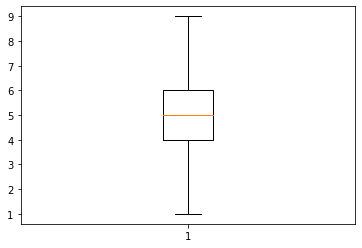

In [33]:
#plt.scatter(df.index,df['doc_visits'])
#plt.show()
plt.boxplot(df.doc_visits)
#plt.boxplot(df.doc_visits_z)

Text(0.5, 0, 'Specimen strength')

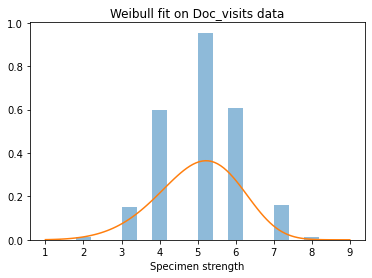

In [34]:
plt.hist(df['doc_visits'], density=True, alpha=0.5, bins=20)
visits = df['doc_visits']
shape, loc, scale = weibull_min.fit(visits, floc=0)
x = np.linspace(visits.min(), visits.max(), 100)
plt.plot(x, weibull_min(shape, loc, scale).pdf(x))
plt.title("Weibull fit on Doc_visits data")
plt.xlabel("Specimen strength")

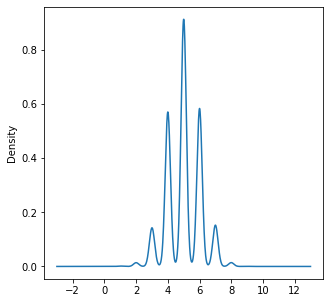

In [35]:
plt.figure(figsize=(5,5))
df['doc_visits'].plot(kind='density')

Univariate Analysis of the varible "Initial_Days", the number of days the patient was admitted for their initial stay. 

{'whiskers': [<matplotlib.lines.Line2D at 0x225a510fe80>,
 'caps': [<matplotlib.lines.Line2D at 0x225a511e5b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x225a510fb20>],
 'medians': [<matplotlib.lines.Line2D at 0x225a511ec70>],
 'fliers': [<matplotlib.lines.Line2D at 0x225a511ef70>],
 'means': []}

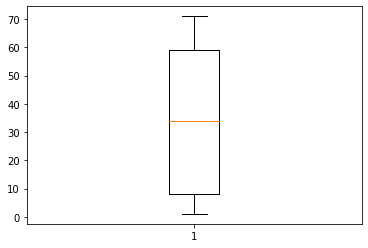

In [36]:
plt.boxplot(df.Initial_Days)

(array([ 336.,  321.,  327.,    0.,  311.,  298.,    0.,  314.,  312.,
           0.,  251.,  242.,  198.,    0.,  185.,  189.,    0.,  161.,
         155.,    0.,  154.,  105.,   91.,    0.,   90.,   65.,    0.,
          65.,   44.,    0.,   37.,   24.,   29.,    0.,   20.,   18.,
           0.,    8.,    9.,    0.,    6.,   10.,    2.,    0.,    2.,
           3.,    0., 1034.,    2.,    0.,   18.,   27.,   25.,    0.,
          26.,   26.,    0.,   41.,   53.,    0.,   36.,   58.,   50.,
           0.,   64.,   63.,    0.,   86.,  101.,    0.,   88.,  106.,
         134.,    0.,  131.,  123.,    0.,  112.,  152.,    0.,  147.,
         176.,  181.,    0.,  141.,  177.,    0.,  194.,  177.,    0.,
         210.,  220.,  200.,    0.,  170.,  209.,    0.,  224.,  206.,
         216.]),
 array([ 1. ,  1.7,  2.4,  3.1,  3.8,  4.5,  5.2,  5.9,  6.6,  7.3,  8. ,
         8.7,  9.4, 10.1, 10.8, 11.5, 12.2, 12.9, 13.6, 14.3, 15. , 15.7,
        16.4, 17.1, 17.8, 18.5, 19.2, 19.9, 20.6, 21.3

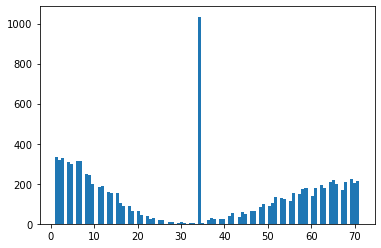

In [37]:
plt.hist(df['Initial_Days'], bins=100)

In [38]:
dfo = pd.read_csv(r"medical_data.csv")

In [39]:
dfo =  dfo[dfo['Initial_Days'].notna()]

In [40]:
dfo.head(5)

,Unnamed: 0,ID,Customer_id,Interaction,UID,zip,Lat,Lng,City,State,Population,County,Area,Timezone,Job,Children,Age,Education,Employment,Income,Marital,ReAdmis,Gender,vitD_levels,doc_visits,full_meals_eaten,vitD_supp,Soft_drink,Initial_Admin,HighBlood,Stroke,Complication_Risk,Overweight,Arthritis,Diabetes,Hyperlipidemia,BackPain,Anxiety,Allergic_rhinitis,Reflux_esophagitis,Asthma,Services,Initial_Days,TotalCharge,Additional_Charges,item1,item2,item3,item4,item5,item6,item7,item8
0,1,1,C412403,8cd49b13-f45a-4b47-a2bd-173ffa932c2f,3a83ddb66e2ae73798bdf1d705dc0932,35621,34,-87,Eva,AL,2951,Morgan,Suburban,America/Chicago,"Psychologist, sport and exercise",1,53,"Some College, Less than 1 Year",Full Time,"86,576",Divorced,No,Male,18,6,0,0,NaN,Emergency Admission,Yes,No,Medium,0,Yes,Yes,No,Yes,1,Yes,No,Yes,Blood Work,11,"3,191","17,939",3,3,2,2,4,3,3,4
1,2,2,Z919181,d2450b70-0337-4406-bdbb-bc1037f1734c,176354c5eef714957d486009feabf195,32446,31,-85,Marianna,FL,11303,Jackson,Urban,America/Chicago,Community development worker,3,51,"Some College, 1 or More Years, No Degree",Full Time,"46,806",Married,No,Female,19,4,2,1,No,Emergency Admission,Yes,No,High,1,No,No,No,No,nan,No,Yes,No,Intravenous,15,"4,215","17,613",3,4,3,4,4,4,3,3
2,3,3,F995323,a2057123-abf5-4a2c-abad-8ffe33512562,e19a0fa00aeda885b8a436757e889bc9,57110,44,-97,Sioux Falls,SD,17125,Minnehaha,Suburban,America/Chicago,Chief Executive Officer,3,53,"Some College, 1 or More Years, No Degree",Retired,"14,370",Widowed,No,Female,17,4,1,0,No,Elective Admission,Yes,No,Medium,1,No,Yes,No,No,nan,No,No,No,Blood Work,5,"2,178","17,505",2,4,4,4,3,4,3,3
3,4,4,A879973,1dec528d-eb34-4079-adce-0d7a40e82205,cd17d7b6d152cb6f23957346d11c3f07,56072,44,-94,New Richland,MN,2162,Waseca,Suburban,America/Chicago,Early years teacher,0,78,GED or Alternative Credential,Retired,"39,741",Married,No,Male,17,4,1,0,No,Elective Admission,No,Yes,Medium,0,Yes,No,No,No,nan,No,Yes,Yes,Blood Work,2,"2,465","12,993",3,5,5,3,4,5,5,5
4,5,5,C544523,5885f56b-d6da-43a3-8760-83583af94266,d2f0425877b10ed6bb381f3e2579424a,23181,38,-77,West Point,VA,5287,King William,Rural,America/New_York,Health promotion specialist,nan,22,Regular High School Diploma,Full Time,"1,210",Widowed,No,Female,17,5,0,2,Yes,Elective Admission,No,No,Low,0,No,No,Yes,No,0,Yes,No,No,CT Scan,1,"1,886","3,717",2,1,3,3,5,3,4,3


(array([354., 326., 338., 321., 316., 323., 310., 263., 242., 218., 189.,
        190., 158., 169., 146.,  99.,  89.,  93.,  66.,  55.,  51.,  32.,
         28.,  23.,  23.,  14.,   7.,   7.,   7.,   8.,   4.,   1.,   2.,
          1.,   9.,  25.,  26.,  27.,  27.,  38.,  43.,  49.,  51.,  50.,
         74.,  54.,  94.,  90.,  89., 109., 126., 136., 137., 120., 136.,
        152., 179., 192., 159., 170., 201., 202., 211., 220., 214., 177.,
        216., 231., 211., 226.]),
 array([ 1.00198092,  2.01597385,  3.02996679,  4.04395972,  5.05795266,
         6.07194559,  7.08593852,  8.09993146,  9.11392439, 10.12791733,
        11.14191026, 12.15590319, 13.16989613, 14.18388906, 15.197882  ,
        16.21187493, 17.22586786, 18.2398608 , 19.25385373, 20.26784667,
        21.2818396 , 22.29583253, 23.30982547, 24.3238184 , 25.33781134,
        26.35180427, 27.3657972 , 28.37979014, 29.39378307, 30.40777601,
        31.42176894, 32.43576187, 33.44975481, 34.46374774, 35.47774068,
        36.

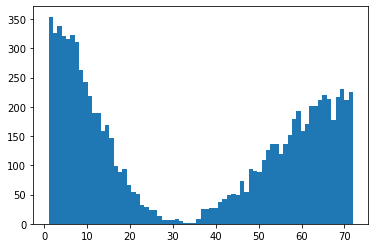

In [41]:
plt.hist(dfo['Initial_Days'], bins=70)

The "Initial_Days" shows a bimodal distribution 

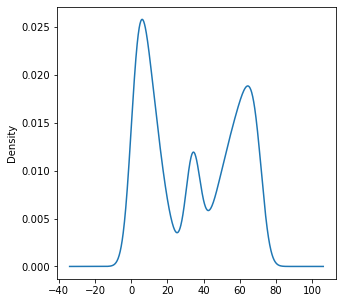

In [42]:
plt.figure(figsize=(5,5))
df['Initial_Days'].plot(kind='density')

Univariate Analysis of the variable "State" which represents the state where the patient lives

(array([1228., 1391., 1381.,  879.,  695.,  805., 1339.,  596.,  315.,
         315.]),
 array([ 0. ,  5.1, 10.2, 15.3, 20.4, 25.5, 30.6, 35.7, 40.8, 45.9, 51. ]),
 <a list of 10 Patch objects>)

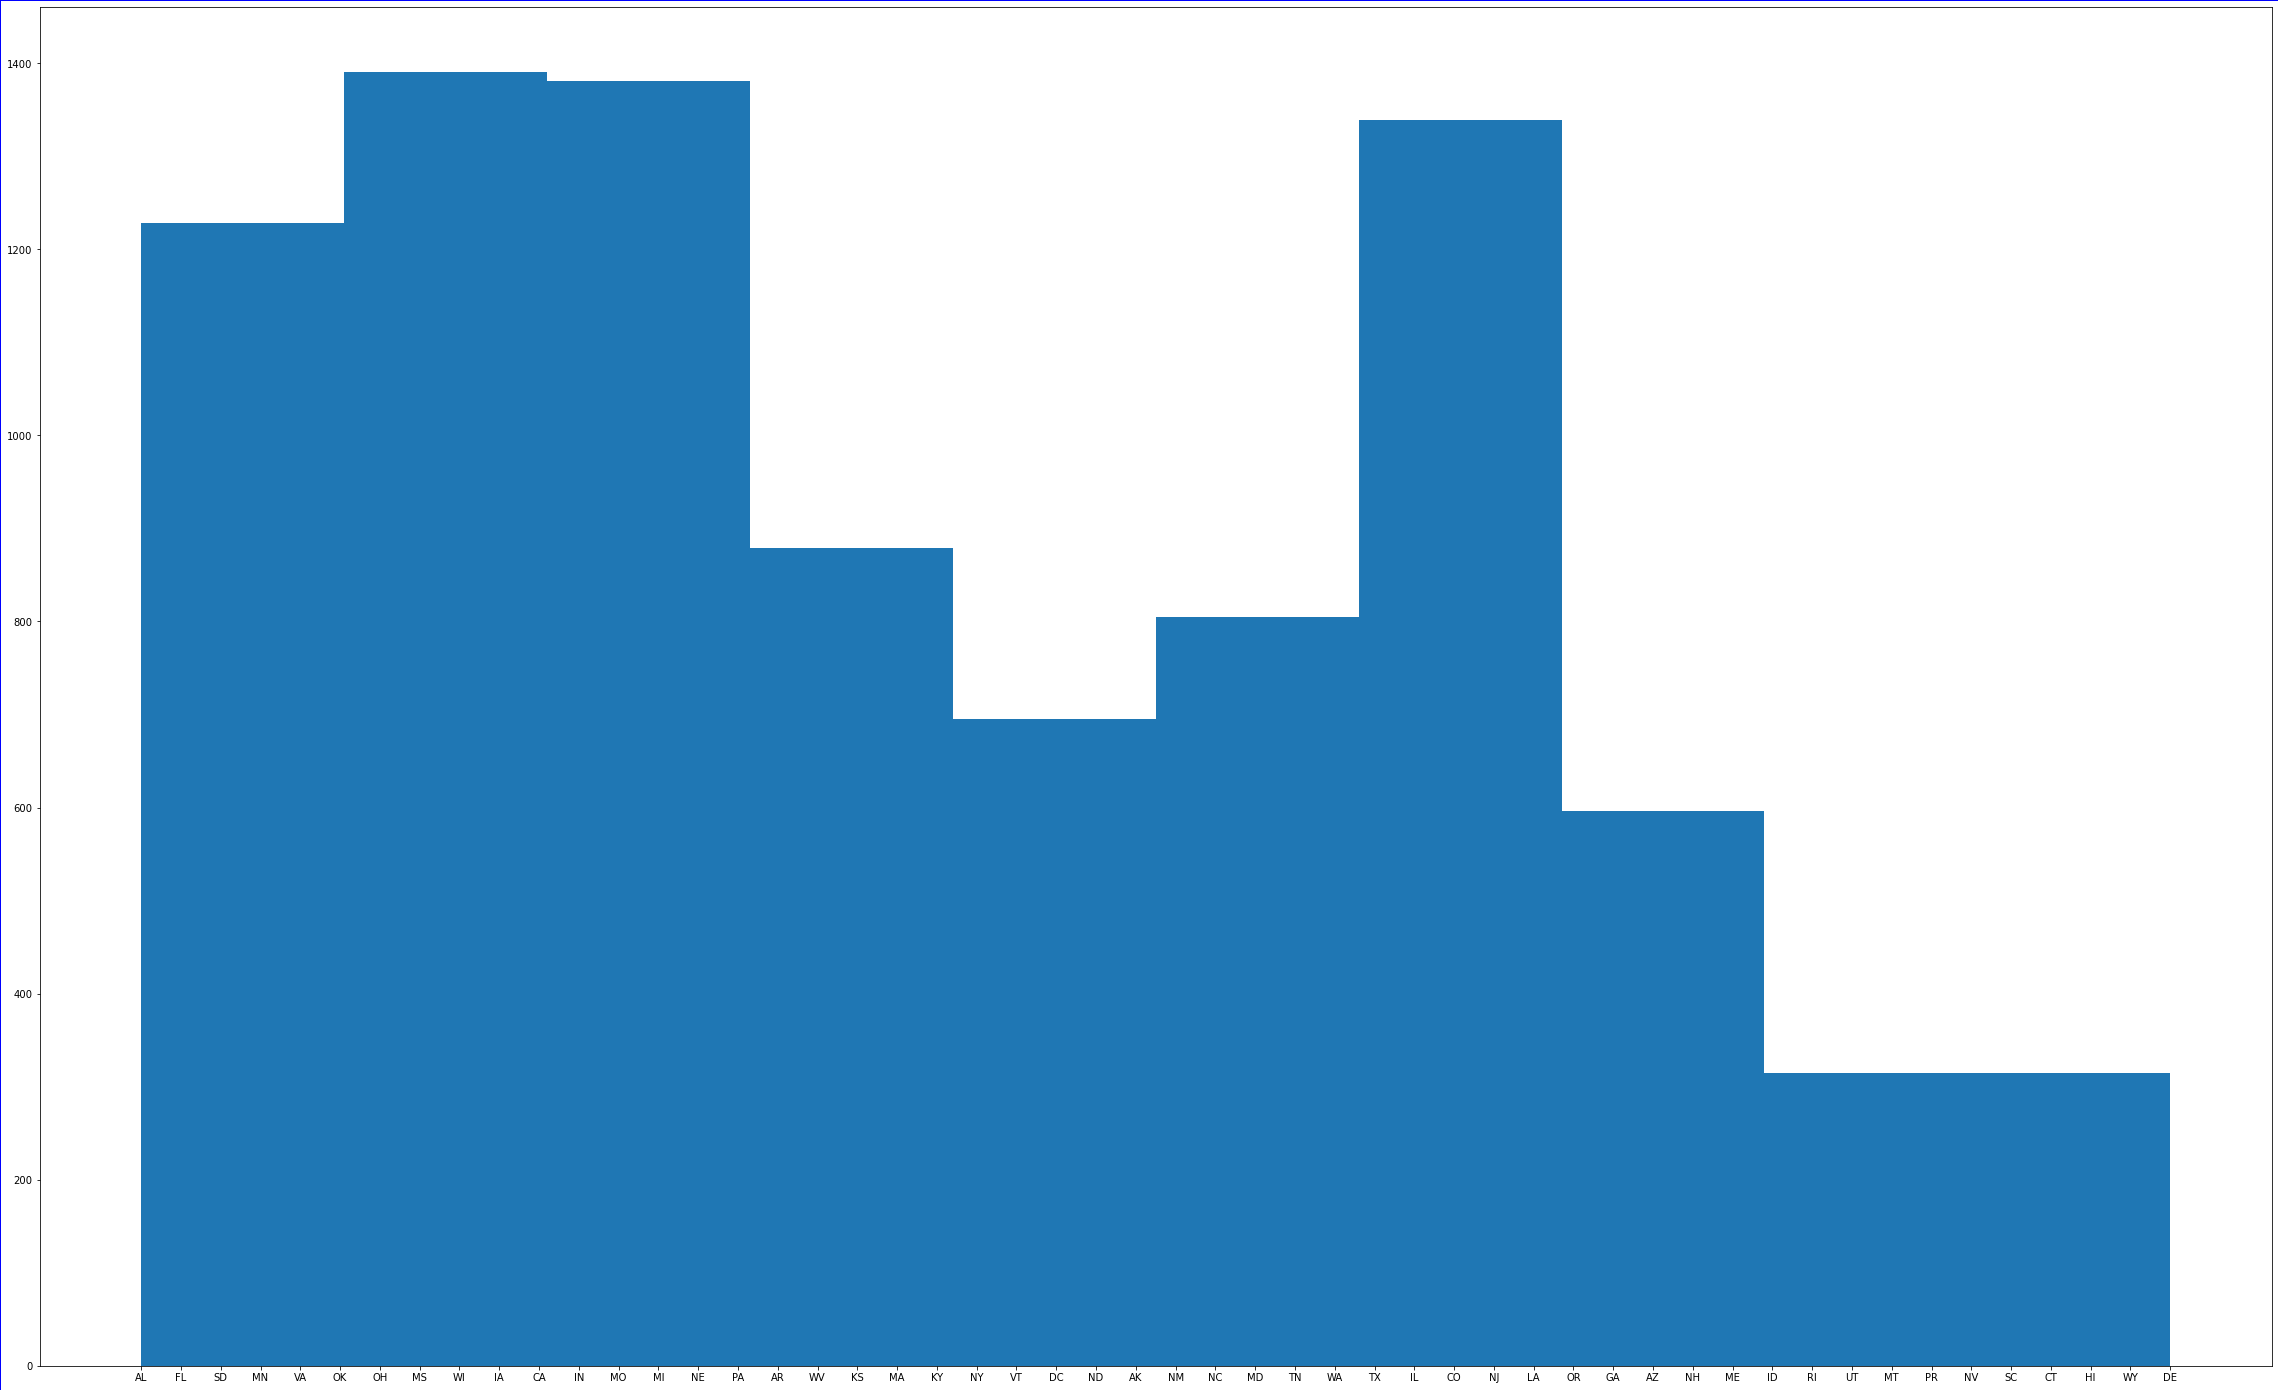

In [43]:
plt.figure(figsize=(40,25),facecolor='white',edgecolor='blue', linewidth=1)#change your figure size as per your desire here
plt.hist(dfo['State'])

([<matplotlib.patches.Wedge at 0x225a5291e80>,
 [Text(1.0836948532329036, 0.18869410450916502, ''),
  Text(0.9563141621355337, 0.5435652889019058, ''),
  Text(0.7184525282354791, 0.832962162809361, ''),
  Text(0.40778537184924785, 1.0216217942593877, ''),
  Text(0.08713228043956599, 1.096543645143868, ''),
  Text(-0.1970379754796809, 1.082208869035395, ''),
  Text(-0.4319378403209412, 1.0116470244600542, ''),
  Text(-0.6225665743097542, 0.9068687118608832, ''),
  Text(-0.7791895983896409, 0.7764428953641024, ''),
  Text(-0.903658954117281, 0.6272164655393399, ''),
  Text(-0.998153924275682, 0.46226479798169406, ''),
  Text(-1.0623811852854836, 0.28521258238621094, ''),
  Text(-1.0946620153102202, 0.10823618728025983, ''),
  Text(-1.0981229709108877, -0.0642334862657001, ''),
  Text(-1.076936238584983, -0.22407217145917277, ''),
  Text(-1.0364510263295341, -0.3684688182471555, ''),
  Text(-0.9781599439157458, -0.5031929293210957, ''),
  Text(-0.9040615060049172, -0.626636093247206, ''),

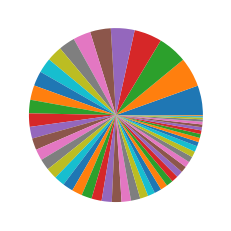

In [44]:
plt.pie(df['State'].value_counts())

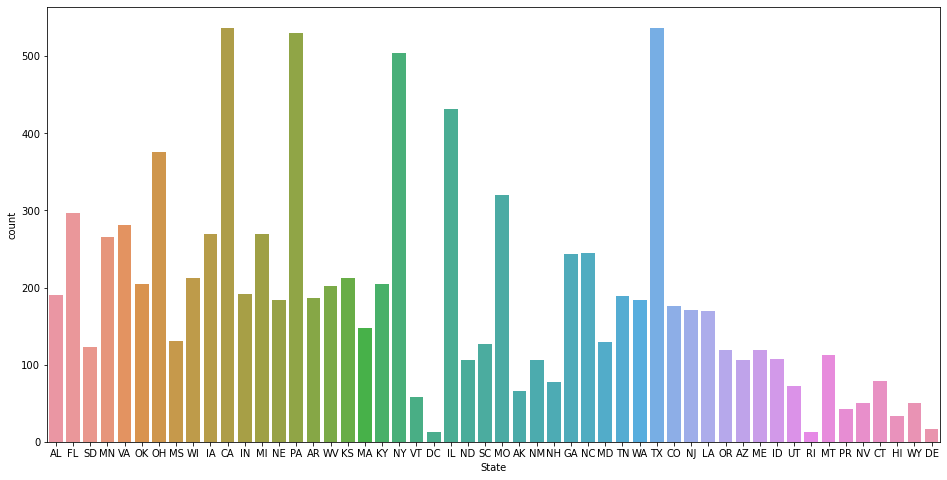

In [45]:
plt.figure(figsize=(16,8))
sns.countplot(x='State', data=df)
plt.show()

Univariate analysis of variable "Initial_Admin" which catogorizes whether the patient was admitted under Emergency admission, elective admission, or observation admission

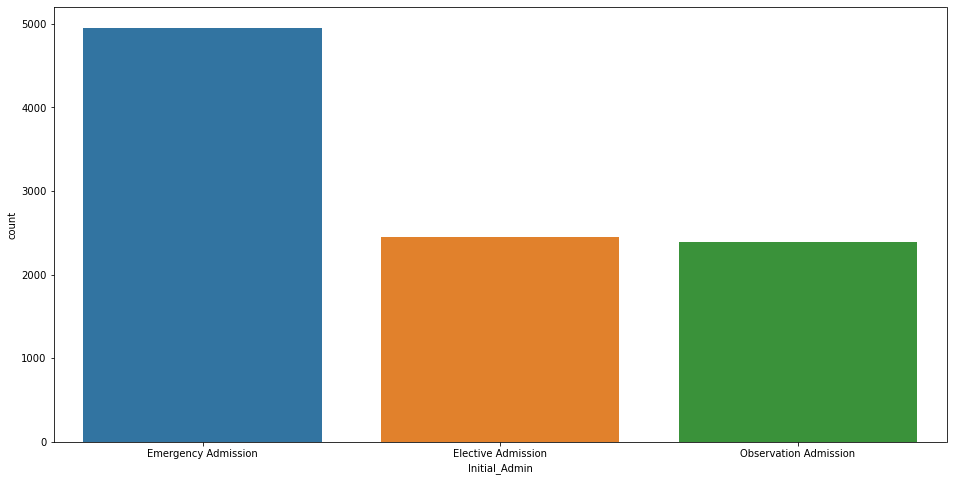

In [46]:
plt.figure(figsize=(16,8))
sns.countplot(x='Initial_Admin', data=df)
plt.show()

Bivariate Analysis of two continuous variables “doc_visits”, “initial_days”  

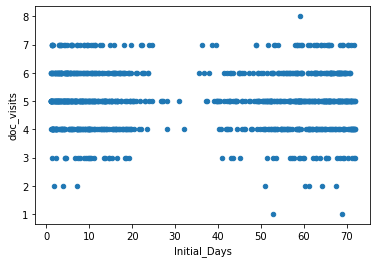

In [47]:
dfo.sample(1000).plot.scatter(x='Initial_Days', y='doc_visits')

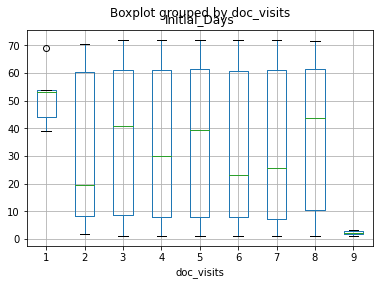

In [48]:
dfo.boxplot(column='Initial_Days', by='doc_visits')

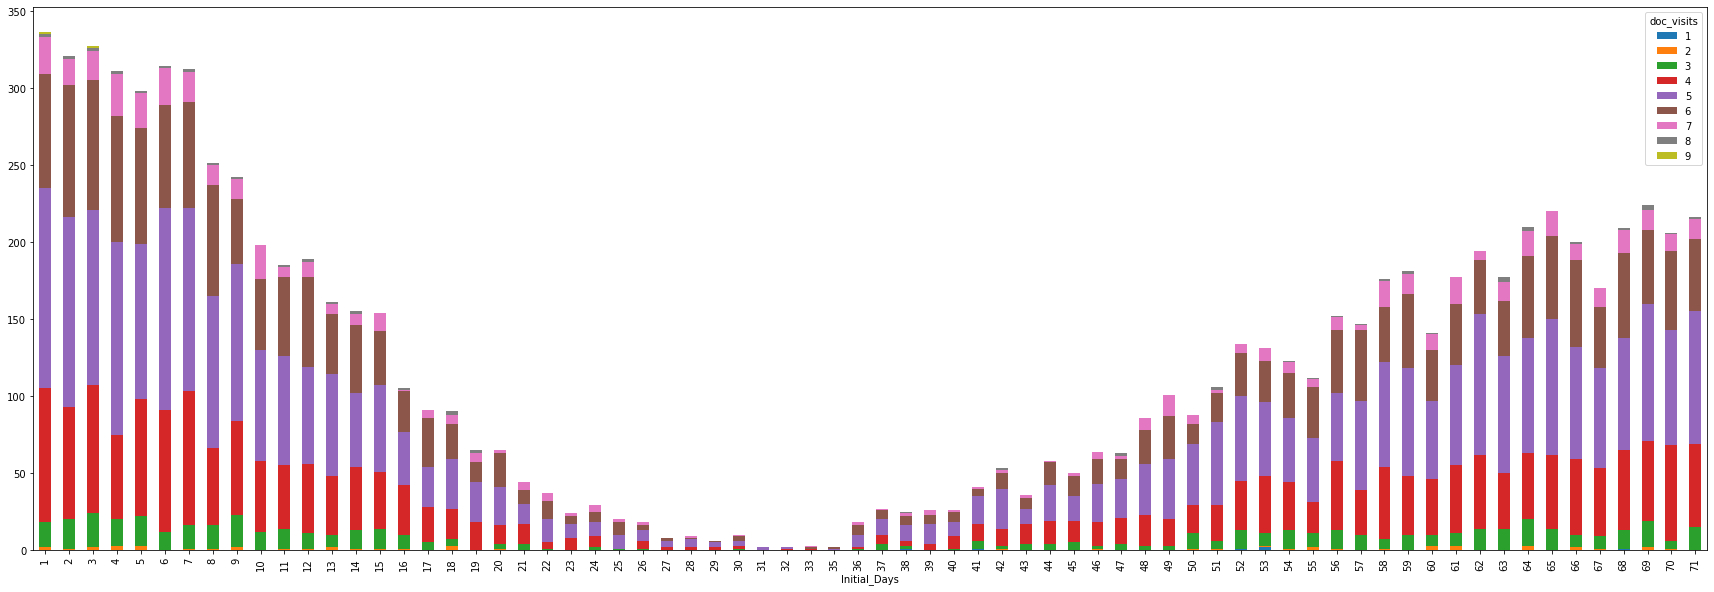

In [49]:
pd.crosstab(df['Initial_Days'], dfo['doc_visits']).plot(kind='bar', stacked=True, figsize=(30,10))

bivariate Analysis of two categorical variables “State”, “Initial_admin” 

In [50]:
#two-way table
grouped =  dfo.groupby(['Initial_Admin','State'])
grouped.size()

Initial_Admin          State
Elective Admission     AK        13
                       AL        34
                       AR        34
                       AZ        26
                       CA       116
                               ... 
Observation Admission  VT        14
                       WA        44
                       WI        43
                       WV        41
                       WY        14
Length: 156, dtype: int64

In [51]:
pd.crosstab(dfo["State"],
            dfo["Initial_Admin"],
            dropna = False,
            margins = True
           )

Initial_Admin,Elective Admission,Emergency Admission,Observation Admission,All
State,,,,
AK,13,38,13,64
AL,34,92,44,170
AR,34,97,42,173
AZ,26,42,26,94
CA,116,243,129,488
CO,32,84,44,160
CT,21,36,15,72
DC,4,4,4,12
DE,2,10,5,17


In [52]:
Percentages of each state admision by category

SyntaxError: invalid syntax (<ipython-input-52-dcb79933fc6d>, line 1)

In [ ]:
pd.crosstab(dfo['State'],
            dfo['Initial_Admin'],
            dropna = False,
            normalize = 'index' # convert absolute to row proportions
           ).round(3)*100

In [ ]:
pd.crosstab(dfo['State'],
            dfo['Initial_Admin'],
            dropna = False,
            normalize = 'columns' # convert absolute to column proportions
           ).round(3)*100